# Layer normalization

### Definition

Input
* $x \in \mathbb{R}^{d_{in}}$ 

Weights
* scale $\gamma \in \mathbb{R}^{d_{in}}$ 
* shift $\beta \in \mathbb{R}^{d_{in}}$

Output
* $o \in \mathbb{R}^{d_{in}}$

$$o = \text{LayerNorm}_{\gamma,\beta}(x)= \gamma * \frac{x - \mu(x)}{\sqrt{\sigma(x)^2 + \varepsilon}} + \beta.$$
where
  $$
  \mu(x) = \frac{1}{d_{in}}\sum_{i=1}^{d_{in}} x_{i}, 
  \qquad
  \sigma(x)^2 = \frac{1}{d_{in}}\sum_{i=1}^{d_{in}} (x_{i} - \mu(x))^2.
  $$


where $*$ denotas the elementwise vector-multiplication and $\epsilon >0$ is a small quantity for avoiding zero division. 

## Code

In [20]:
import torch
import torch.nn as nn

In [ ]:
class LayerNorm(nn.Module):
    """
    This version is designed for readability and to expose the internal logic of
    layer normalization.
    It behaves similarly to `torch.nn.LayerNorm` but may differ slightly in
    numerical values due to floating-point accumulation order and lack of low-level
    optimizations.
    """
    def __init__(self, normalized_shape, eps=1e-5, elementwise_affine=True):
        super().__init__()
        if isinstance(normalized_shape, int):
            normalized_shape = (normalized_shape,)
        self.normalized_shape = normalized_shape
        self.normalized_dim = len(self.normalized_shape)
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.ones(self.normalized_shape))
            self.bias = nn.Parameter(torch.zeros(self.normalized_shape))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)

    def forward(self, x):
        # Compute mean and variance over last N dims
        dim = tuple(range(x.dim() - self.normalized_dim, x.dim()))
        mean = x.mean(dim=dim, keepdim=True)
        var = x.var(dim=dim, unbiased=False, keepdim=True)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        if self.elementwise_affine:
            x_norm = x_norm * self.weight + self.bias
        return x_norm

## Testing

### Weights

In [42]:
layernorm=LayerNorm(normalized_shape=(3,5))
nn_layernorm = nn.LayerNorm(normalized_shape=(3,5))
print('nn layernorm')
for name, w in layernorm.named_parameters():
    print(f'{name} {w}')
print('\ncustom layernorm')
for name,w in nn_layernorm.named_parameters():
   print(f'{name} {w}')

nn layernorm
weight Parameter containing:
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], requires_grad=True)
bias Parameter containing:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], requires_grad=True)

custom layernorm
weight Parameter containing:
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], requires_grad=True)
bias Parameter containing:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], requires_grad=True)


### output

In [43]:
x = torch.randn(3,4,2)
layernorm=LayerNorm(normalized_shape=(4,2))
nn_layernorm = nn.LayerNorm(normalized_shape=(4,2))
output = layernorm(x)
output_nn = nn_layernorm(x)
print(output)
print(output_nn)

tensor([[[-0.5766, -0.9435],
         [ 0.3744, -0.7576],
         [-1.3632,  0.9878],
         [ 0.5768,  1.7019]],

        [[-1.3090, -0.7961],
         [-0.8870,  0.0785],
         [-0.2580,  0.1468],
         [ 1.1990,  1.8259]],

        [[ 0.0225,  1.5308],
         [ 0.7294, -0.0417],
         [-0.9375, -0.6035],
         [ 0.9980, -1.6980]]], grad_fn=<AddBackward0>)
tensor([[[-0.5766, -0.9435],
         [ 0.3744, -0.7576],
         [-1.3632,  0.9878],
         [ 0.5768,  1.7019]],

        [[-1.3090, -0.7961],
         [-0.8870,  0.0785],
         [-0.2580,  0.1468],
         [ 1.1990,  1.8259]],

        [[ 0.0225,  1.5308],
         [ 0.7294, -0.0417],
         [-0.9375, -0.6035],
         [ 0.9980, -1.6980]]], grad_fn=<NativeLayerNormBackward0>)


### Output (stacked layernorms)
Notice that the custom implementation differ slightly in numerical values due to floating-point accumulation order

In [44]:
class MLPLN(nn.Module):
    def __init__(self, ln_net_cls, input_dim, hidden_dim, output_dim, pos=False):
        super().__init__()
        layers = [nn.Flatten()]
        in_dim = input_dim
        for h_dim in hidden_dim:
            if pos:
                layers.append(nn.Linear(in_dim, h_dim,bias=False)) # bias learned by LinearLayer
                if in_dim > 1:
                    layers.append(ln_net_cls(h_dim)) 
            else:
                # Only pass elementwise_affine if using nn.LayerNorm
                if in_dim > 1:
                    layers.append(ln_net_cls(in_dim, elementwise_affine=False))
                layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim, bias=False))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [45]:
x = torch.randn(5, 28, 28)
torch.manual_seed(1)
out_refs = []
for i in range(10):
    net = MLPLN(nn.LayerNorm,input_dim=28*28, hidden_dim=i*[512], output_dim=100)
    out= net(x)
    out_norm=out.norm().item()
    print(f'{i} - {out_norm = }')
    out_refs.append(out)


0 - out_norm = 11.990492820739746
1 - out_norm = 4.957279205322266
2 - out_norm = 5.085205554962158
3 - out_norm = 5.53076696395874
4 - out_norm = 5.040024757385254
5 - out_norm = 5.355479717254639
6 - out_norm = 5.200225830078125
7 - out_norm = 5.364978790283203
8 - out_norm = 4.808578014373779
9 - out_norm = 5.301670074462891


In [46]:
torch.manual_seed(1)
for i in range(10):
    net = MLPLN(LayerNorm,input_dim=28*28, hidden_dim=i*[512], output_dim=100)
    out = net(x)
    out_norm = out.norm().item()
    print(f'{i} - {out_norm = } - allclose: {torch.allclose(out_refs[i], out, atol=1e-5, rtol=0.0)}')

0 - out_norm = 11.990492820739746 - allclose: True
1 - out_norm = 4.957278251647949 - allclose: True
2 - out_norm = 5.085206031799316 - allclose: True
3 - out_norm = 5.530767440795898 - allclose: True
4 - out_norm = 5.040024757385254 - allclose: True
5 - out_norm = 5.355479717254639 - allclose: True
6 - out_norm = 5.20022439956665 - allclose: True
7 - out_norm = 5.364977836608887 - allclose: True
8 - out_norm = 4.808577060699463 - allclose: True
9 - out_norm = 5.301669597625732 - allclose: True


### Train 

In [25]:
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

#### generate data

In [55]:
def f(x):
    return 1+2*x**2

torch.manual_seed(3)
N = 32
xs = (4*torch.rand(N)-2)[:,None]
ys = f(xs) + 0.5*torch.randn(N,1)
x_eval = torch.linspace(-2,2,100)

dataset = TensorDataset(xs, ys)

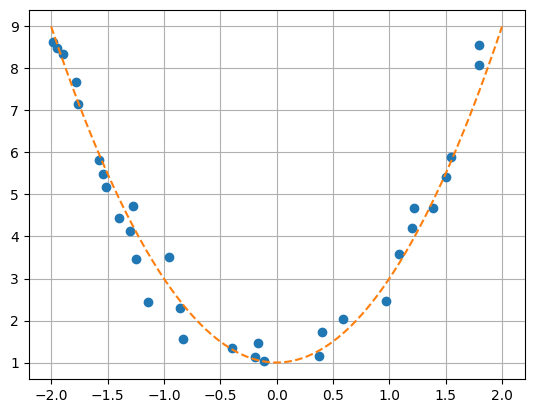

In [56]:
plt.plot(xs[:,0].detach().numpy(), ys[:,0].detach().numpy(), 'o')
plt.plot(x_eval.detach().numpy(), f(x_eval).detach().numpy(), '--')
plt.grid()
plt.show()

In [57]:
lr = 0.001
momentum = 0.9
batch_size = N//4
hidden_dim = [64,64]
loss_fn = nn.MSELoss()  
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### trainning

##### Torch LayerNorm

In [58]:
torch.manual_seed(1)

nn_model = MLPLN(nn.LayerNorm,
                   input_dim=1, 
                   hidden_dim=hidden_dim, 
                   output_dim=1)
opt = torch.optim.SGD(nn_model.parameters(), lr=lr, momentum=momentum)

nn_model.train()
torch_losses = []
for epoch in range(100):
    for x, y in data_loader:
        preds = nn_model(x)
        loss  = loss_fn(preds, y)
        loss.backward()
        opt.step()
        opt.zero_grad()  
        torch_losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 40.396690368652344
Epoch 10, Loss: 1.0638784170150757
Epoch 20, Loss: 0.5524770617485046
Epoch 30, Loss: 0.3247068524360657
Epoch 40, Loss: 0.2178289294242859
Epoch 50, Loss: 0.3175789415836334
Epoch 60, Loss: 0.2672629952430725
Epoch 70, Loss: 0.08361178636550903
Epoch 80, Loss: 0.06621374189853668
Epoch 90, Loss: 0.19932283461093903


##### Custom LayerNorm

In [59]:
torch.manual_seed(1)
model = MLPLN(LayerNorm,input_dim=1, hidden_dim=hidden_dim, output_dim=1)
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
model.train()
my_losses = []

for epoch in range(100):
    for x, y in data_loader:
        preds = model(x)
        loss  = loss_fn(preds, y)
        loss.backward()
        opt.step()
        opt.zero_grad()  
        my_losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        

Epoch 0, Loss: 40.396690368652344
Epoch 10, Loss: 1.0638785362243652
Epoch 20, Loss: 0.5524773597717285
Epoch 30, Loss: 0.32470718026161194
Epoch 40, Loss: 0.21782901883125305
Epoch 50, Loss: 0.3175784647464752
Epoch 60, Loss: 0.2672632336616516
Epoch 70, Loss: 0.08361166715621948
Epoch 80, Loss: 0.06621375679969788
Epoch 90, Loss: 0.19932283461093903


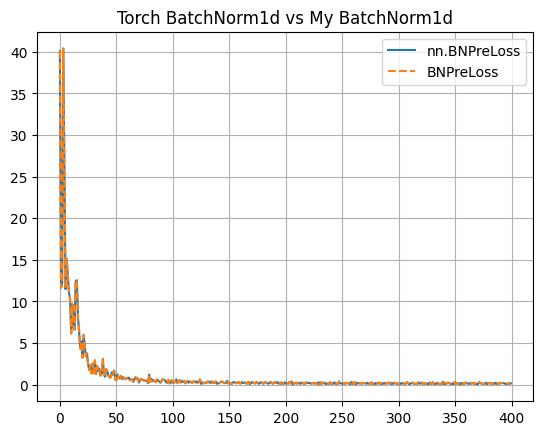

In [60]:
plt.plot(torch_losses,linestyle="-",label="nn.BNPreLoss")
plt.plot(my_losses,linestyle="--",label="BNPreLoss")
plt.title("Torch BatchNorm1d vs My BatchNorm1d")
plt.grid(True)
plt.legend()
plt.show()

### Evaluation

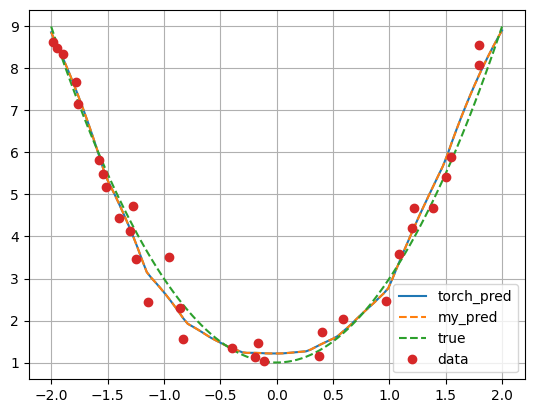

In [61]:
nn_model.eval()
model.eval()

plt.plot(x_eval,nn_model(x_eval[:,None]).squeeze().detach().numpy(), '-',label='torch_pred')
plt.plot(x_eval,model(x_eval[:,None]).squeeze().detach().numpy(), '--',label='my_pred')
plt.plot(x_eval,f(x_eval), '--',label='true')
plt.plot(xs[:,0].detach().numpy(), ys[:,0].detach().numpy(), 'o',label='data')
plt.legend()
plt.grid()
plt.show()